# Plot model comparisons

This notebook uses results from Code/results/ to generate plots comparing distributions.


It contains function to calculate for each setup:

1. MSE between reconstructed means and 'simulated/exact' means per cell.
2. Pearson correlation between reconstructed means and 'simulated/exact' means per cell.
3. nearest neighbor metrics: what percent of top N nearest neighbors are in same cluster
4. Alpha? Correlation coefficient maybe? 

In [115]:
# import argparse
# parser = argparse.ArgumentParser()

# parser.add_argument('--name', type=str)
# parser.add_argument('--data_dir', type=str)
# args = parser.parse_args()

# name = args.name
# data_dir = args.data_dir
# print(f'working on {name}')


import matplotlib.pyplot as plt


# System
import sys
sys.path.insert(0, '../analysis_scripts/')

# Math
import numpy as np
import torch
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# scvi
import anndata
import scanpy as sc


# nearest neighbor classifiers and pearson correlation calculators
from sklearn.neighbors import KNeighborsClassifier 
from scipy import stats #function: stats.pearsonr(x,y)
    

# Define metric functions

1. MSE
2. Pearson correlation coefficient
3. Nearest neighbors (using euclidean distance)



In [125]:
def calc_MSE(x,y):
  '''Calculate the MSE between x and y between vectors of the first axis in the x and y matrices.
  params
  -------
  x : (N,Z)
  y : (N,Z)
  
  returns
  -------
  MSE_array : N '''

  MSE = (x-y)**2
  MSE_array = np.sum(MSE,axis=1)/x.shape[1]
  return(MSE_array)


def calc_MSE_1D(x,y):
  '''Calculate the MSE between x and y.
  params
  -------
  x : (Z)
  y : (Z)
  
  returns
  -------
  MSE : 1'''

  MSE_ = (x-y)**2
  MSE = np.sum(MSE_)/len(x)
  return(MSE)




def nn_percentages(x,N,cluster_assignments):
  ''' Calculate the percentage of nearest neighbors in the same cluster.

  params
  ------
  x : (N,Z) N cells, Z latent space
  cluster_assignments : cluster assignments for vectors in x

  returns
  -------
  nn_perecent_array = (N) percent of N nearest neighbors in same cluster for each vector of x
  '''

  # set up nearest neighbor class
  neigh = KNeighborsClassifier(n_neighbors=N)
  # fit model
  neigh.fit(x,cluster_assignments)
  # calculate nearest neighbor distance and indices to top N neighbors for all vectors in x
  neigh_distance, neigh_ind = neigh.kneighbors()

  # get the percent of nearest neighbors!
  nn_percent_array = np.array([ len(cluster_assignments[n][cluster_assignments[n] == cluster_assignments[i]])/N for i,n in enumerate(neigh_ind) ])

  return nn_percent_array



def get_metrics(name,results_dict,adata,index,N=100):
  ''' Given results_dict from model training, returns MSE between simulated/recon means, Pearson correlation between simulated/recon means,
  and percentage of N nearest neighbors in the same cluster assignment for all cells. 


  params
  ------
  results_dict containing keys:
    ['X_{z}','runtime','df_history','params','recon_error','cell_type']

  outputs
  -------
  metric_dict containing keys:
    ['MSE_S','MSE_U',Pearson_R_S',Pearson_R_U','nearest_neighbors']
  '''

  # set up dictionary to store things in with the training setups as keys
    
  setups = list(results_dict.keys())
  metric_dict = { setup : {} for setup in setups}
  z = list(results_dict[setups[0]].keys())[0][2:]
  print(z)


  # get observed means and dispersions
  obs_means_U = adata[index,adata.var['Spliced']==0].layers['counts'].toarray()
  obs_means_S = adata[index,adata.var['Spliced']==1].layers['counts'].toarray()
  obs_means = adata[index,:].layers['counts'].toarray()


  for setup in setups:
    print(setup)

    setup_dict = results_dict[setup]

    setup_metric_dict = {}

    # unpack dictionary
    X_z = setup_dict[f'X_{z}'][index]
    
    if '.U' in setup:
      recon_means_U = setup_dict['params']['mean'][index,:]
      setup_metric_dict['MSE_U'] = np.array([ calc_MSE_1D(recon_means_U[i],obs_means_U[i]) for i in range(len(X_z)) ])
      setup_metric_dict['Pearson_R_U'] = np.array([ stats.pearsonr(recon_means_U[i], obs_means_U[i])[0] for i in range(len(X_z)) ])

    elif '.S' in setup:
      recon_means_S = setup_dict['params']['mean'][index,:]
      setup_metric_dict['MSE_S'] = np.array([ calc_MSE_1D(recon_means_S[i],obs_means_S[i]) for i in range(len(X_z)) ])
      setup_metric_dict['Pearson_R_S'] = np.array([ stats.pearsonr(recon_means_S[i], obs_means_S[i])[0] for i in range(len(X_z)) ])
    
    else:
      recon_means_U = setup_dict['params']['mean'][index,:int(setup_dict['params']['mean'].shape[1]/2)]
      recon_means_S = setup_dict['params']['mean'][index,int(setup_dict['params']['mean'].shape[1]/2):]
      setup_metric_dict['MSE_U'] = np.array([ calc_MSE_1D(recon_means_U[i], obs_means_U[i]) for i in range(len(X_z)) ])
      setup_metric_dict['Pearson_R_U'] = np.array([ stats.pearsonr(recon_means_U[i], obs_means_U[i])[0] for i in range(len(X_z)) ])
      setup_metric_dict['MSE_S'] = np.array([ calc_MSE_1D(recon_means_S[i], obs_means_S[i]) for i in range(len(X_z)) ])
      setup_metric_dict['Pearson_R_S'] = np.array([ stats.pearsonr(recon_means_S[i], obs_means_S[i])[0] for i in range(len(X_z)) ])


#     if (('.P' not in setup) and ('const' not in name)):      
#       recon_disp = setup_dict['params']['dispersions']
#       setup_metric_dict['alpha correlation'] = stats.pearsonr(sim_disp[0],recon_disp[0,:2000])[0]
    setup_metric_dict['nearest_neighbors'] = nn_percentages(X_z,N,cluster_assignments[index])

    metric_dict[setup] = setup_metric_dict

  return(metric_dict)


# Load in data 

NICE.

Now load in data and see if it works.


Run analysis.

Make nice plots.

Bam. 


In [87]:
!mkdir ../results/B08_processed_hv_figs/

mkdir: cannot create directory ‘../results/B08_processed_hv_figs/’: File exists


In [117]:
# open a file, where you stored the pickled data
name = 'const_5ct'
data_dir = '../data/simulated_data/'
results_file = open(f'../results/{name}_results_dict.pickle', 'rb')
# dump information to that file
results_dict = pickle.load(results_file)
results_file.close()

# # change to hdf5 file if that is what you store data as
adata = anndata.read_loom(data_dir+f'{name}.loom')

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [118]:
adata.shape

(6000, 4000)

In [119]:
cluster_assignments = results_dict.pop('Cell Type')
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')

print(len(test_index))
print(len(train_index))
print(len(np.unique(np.array(cluster_assignments))))


1200
4800
5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


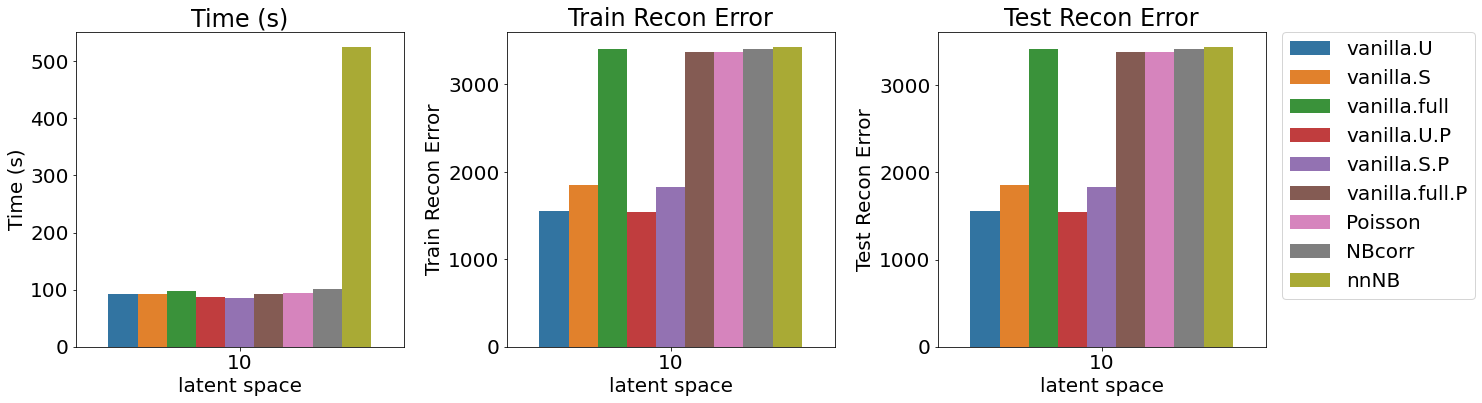

In [120]:
# # Plot Metrics

def plot_recon_loss(results_dict,kind):
  setups = list(results_dict.keys())

  df_plot = pd.concat([pd.DataFrame({'Train Recon Error': -np.array(item[1]['recon_error'])[:,0],
                                   'Test Recon Error': -np.array(item[1]['recon_error'])[:,1],
                                   'Time (s)': item[1]['runtime'][0],
                                   'Setup': item[0].split('-')[0],
                                   'latent space' : item[0].split('-')[1],
                                   'Constant' : item[0].split('-')[2]},index=[i]) for i,item in enumerate(results_dict.items())])



  fig,axes =plt.subplots(1,len(kind),figsize= (7*len(kind),6))
  for i,k in enumerate(kind):
      ax = axes[i]
      _ = sns.barplot(data=df_plot, x='latent space', y=k, hue='Setup', ax=ax)
      ax.get_legend().remove()
      ax.set_title(f'{k}')
      #ax.xticks(rotation=45)
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.tight_layout()

  return(df_plot)


plot_recon_loss(results_dict,kind=['Time (s)','Train Recon Error','Test Recon Error']);
plt.savefig(f'../results/{name}_figs/recon_loss.png')



# Pot MSE, Pearson R, NN Accuracy

In [121]:
def get_df_plot(metric_df,metric):
  ''' Returns a dataframe in an easily plot-able format given metric_df and the metric targetted to plot. 
  '''

  plot_dict = {}

  for setup in metric_df.keys():

    print()
    setup_df = metric_df[setup]

    if metric in setup_df.keys():
 
      plot_dict[setup[:-13]] = setup_df[metric]
      

  if 'alpha' in metric:
    df_plot = pd.DataFrame(plot_dict,index=[0])
  else:
    df_plot = pd.DataFrame(plot_dict)
    
  return(df_plot)

def plot_metrics(metric_dict,name,metrics,T,zoom=None):
    
  fig,axes = plt.subplots(1,len(metrics),figsize= (8*len(metrics),10))
  print(len(axes))
  #plt.xticks(rotation=90)
  for i,m in enumerate(metrics):
    ax = axes[i]
    plot_df = get_df_plot(metric_dict,m)
    _ = sns.boxplot(x="variable", y="value", data=plot_df.melt().dropna(),ax=ax)
    ax.set_title(f'{name}, {m} {T}')
    ax.tick_params(labelrotation=90)
    if zoom is not None:
        ax.set_ylim(0,100)
    ax.set_xlabel('setup')
    ax.set_ylabel(f'{m}')
      #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    

### AND PLOT

10
vanilla.U-10-NAS_SHAPE
vanilla.S-10-NAS_SHAPE
vanilla.full-10-NAS_SHAPE
vanilla.U.P-10-NAS_SHAPE
vanilla.S.P-10-NAS_SHAPE
vanilla.full.P-10-NAS_SHAPE
Poisson-10-NAS_SHAPE
NBcorr-10-NAS_SHAPE
nnNB-10-NAS_SHAPE
2


















2



























10
vanilla.U-10-NAS_SHAPE
vanilla.S-10-NAS_SHAPE
vanilla.full-10-NAS_SHAPE
vanilla.U.P-10-NAS_SHAPE
vanilla.S.P-10-NAS_SHAPE
vanilla.full.P-10-NAS_SHAPE
Poisson-10-NAS_SHAPE
NBcorr-10-NAS_SHAPE
nnNB-10-NAS_SHAPE
2


















2





























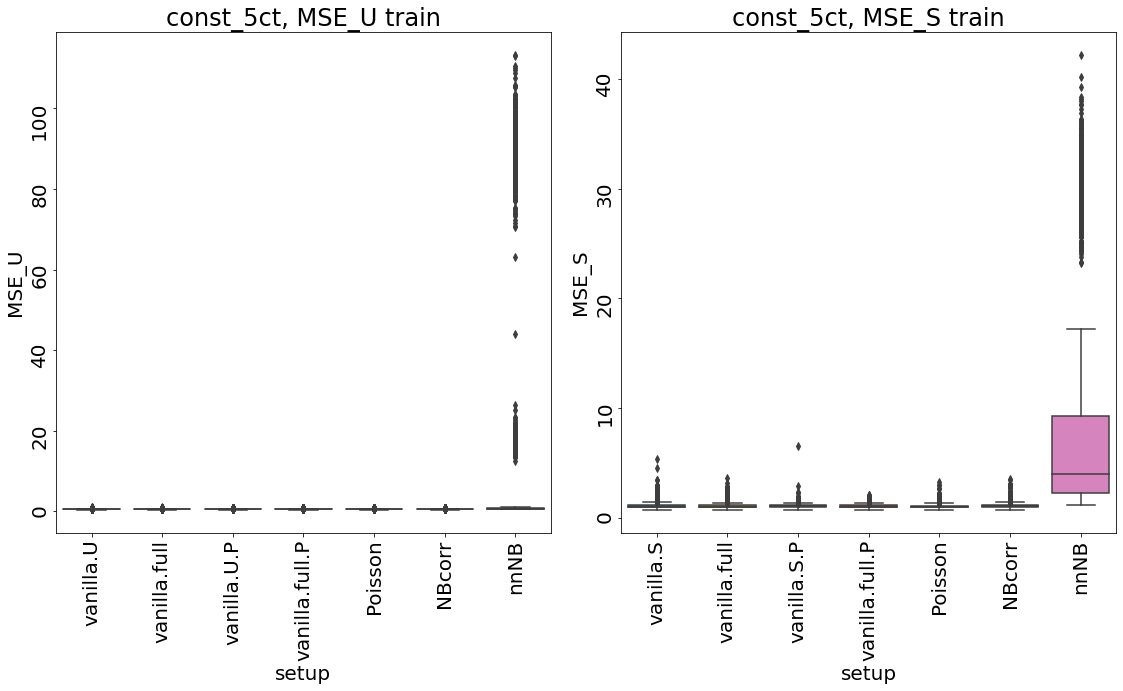

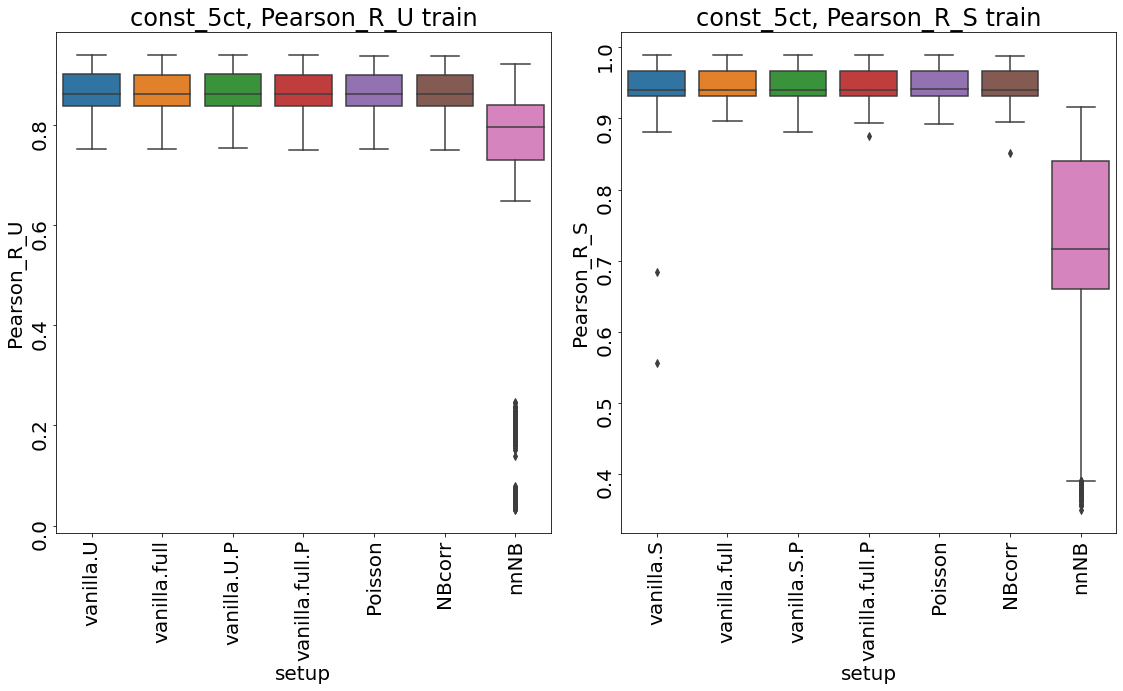

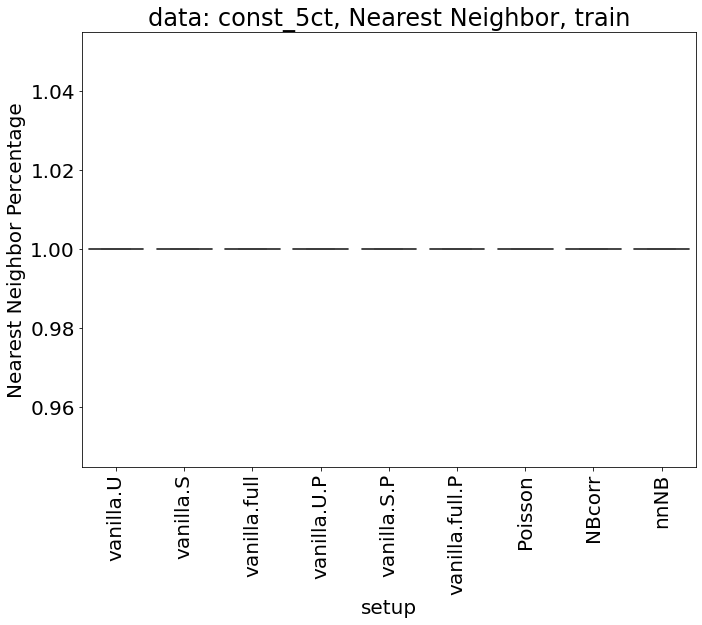

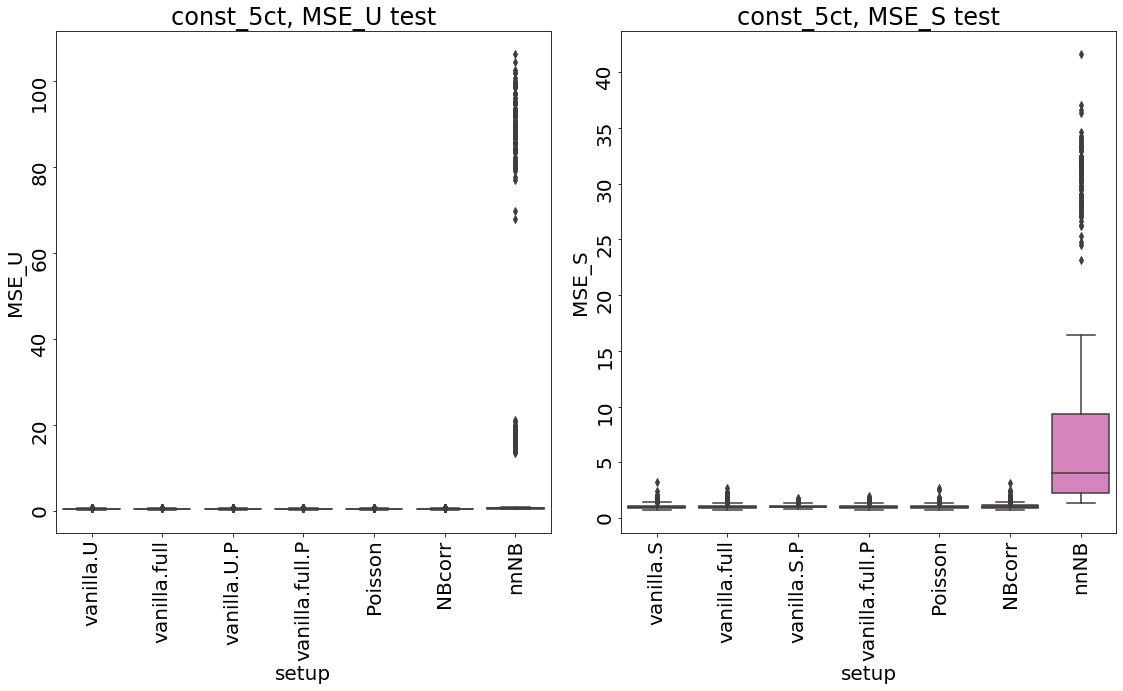

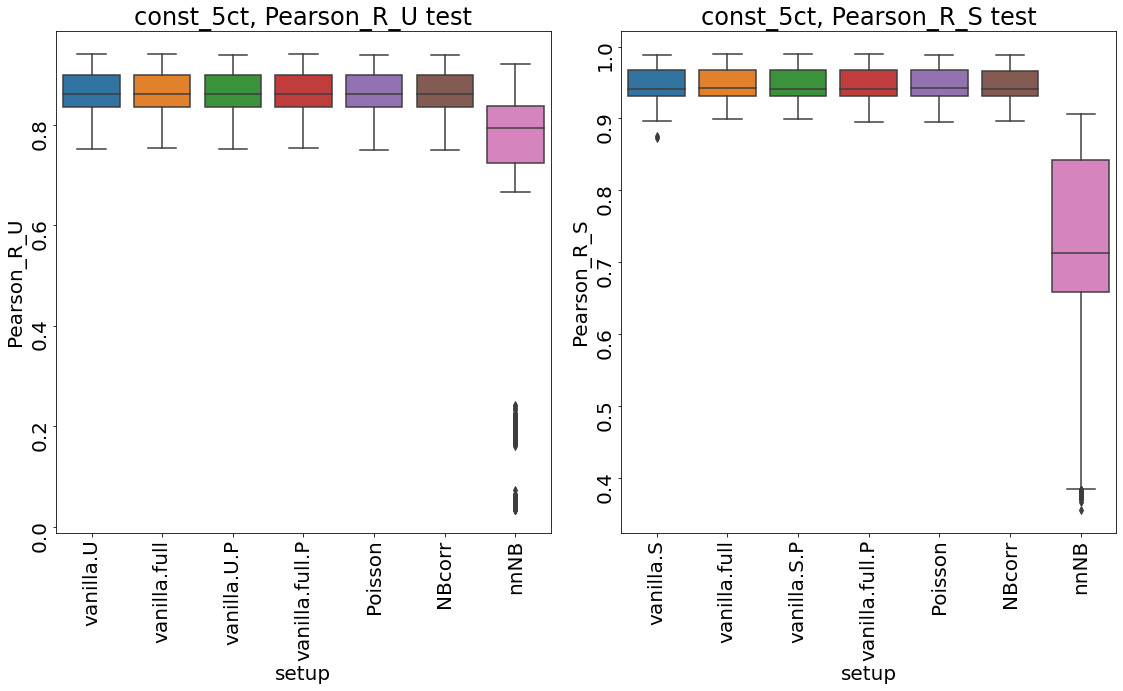

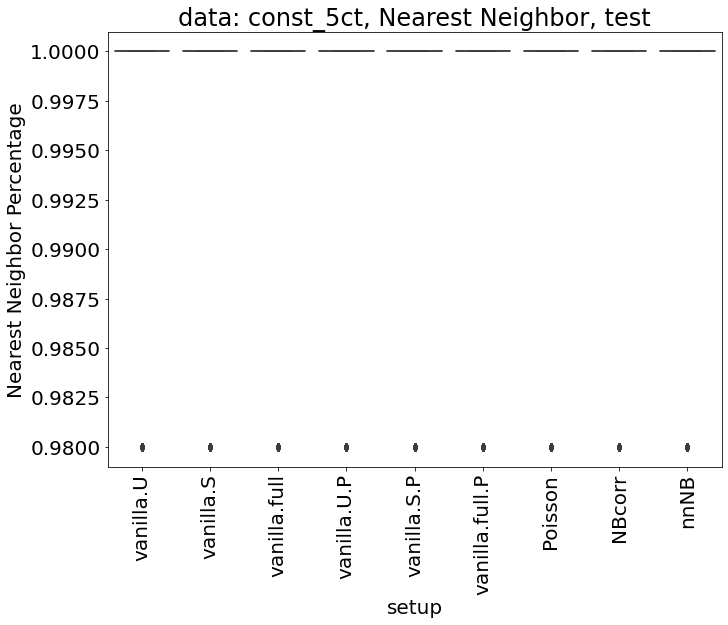

In [127]:
# # Calculate MSE, Pearson R, and Nearest Neighbor accuracy

for T in ['train','test']:
    
    if T == 'train':
        index = train_index
    else:
        index = test_index
        
    metric_dict = get_metrics(name,results_dict,adata,index,N=100)

    metrics = ['MSE_U','MSE_S']
    plot_metrics(metric_dict,name,metrics,T,zoom=None)
    plt.savefig(f'../results/{name}_figs/MSE_{T}_zoom.png')

    metrics = ['Pearson_R_U','Pearson_R_S']
    plot_metrics(metric_dict,name,metrics,T)
    plt.savefig(f'../results/{name}_figs/Pearson_R_{T}.png')

    plot_df = get_df_plot(metric_dict,metric='nearest_neighbors')
    plt.figure(figsize=(11, 8))
    sns.boxplot(x="variable", y="value", data=plot_df.melt().dropna())
    plt.xticks(rotation=90)
    plt.xlabel('setup')
    plt.ylabel('Nearest Neighbor Percentage')
    plt.title(f'data: {name}, Nearest Neighbor, {T}')
    plt.savefig(f'../results/{name}_figs/alpha_corr_{T}.png')

In [124]:
results_dict.keys()

dict_keys(['vanilla.U-10-NAS_SHAPE', 'vanilla.S-10-NAS_SHAPE', 'vanilla.full-10-NAS_SHAPE', 'vanilla.U.P-10-NAS_SHAPE', 'vanilla.S.P-10-NAS_SHAPE', 'vanilla.full.P-10-NAS_SHAPE', 'Poisson-10-NAS_SHAPE', 'NBcorr-10-NAS_SHAPE', 'nnNB-10-NAS_SHAPE'])